<p style="border:2px solid black"> </p>
<span style="font-family:Lucida Bright;">
<p style="margin-bottom:0.8cm"></p>
<center>
<font size="6"><b>Understanding Music Listening Habits</b></font>
<p style="margin-bottom:-0.1cm"></p>
<font size="6"><b>Using Large-scale Smartphone Data</b>  </font>
    
<p style="margin-bottom:0.5cm"></p>
<font size="3"><b>Wojciech Mazurkiewicz, DTU, 14 May 2021</b></font>
<p style="margin-bottom:1cm"></p>
<font size="5"><b>Initial Statistics</b></font>
<br>
<font size="3"><b></b></font>
</center>
<p style="margin-bottom:0.4cm"></p>
<p style="border:2px solid black"> </p>


# Initialization
<hr style="border:2px solid black"></hr>


Please note that the pregenerated cell outputs will not display correctly unless the notebook is **trusted**.

The initializaiton procedure is defined in the notebook [Initialization](initialization.ipynb).

In [1]:
%run initialization.ipynb

# Create a Spark session
<hr style="border:2px solid black"></hr>


In [2]:
#%% Initialize a Spark session.
spark = t.spark.create_session('Music_Activity')

# Set this for faster conversion from Spark to pandas.
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Creating a Spark session.
	Execution time: 6.97632 s.


# Load clean data
<hr style="border:2px solid black"></hr>


In [3]:
# Define the path to the data.
data_path = Config.Path.music_data_clean_root

# Load the data into a clean dataframe
df_full = t.load_data_from_files(data_path,
                                 spark,
                                 method='parquet')

# Drop the column: "user_id_prefix".
df_full = df_full.drop('user_id_prefix')

# Set the flag that determines whether the results
# will be shown.
display_middle_results = True

# Display the table.
if display_middle_results:
    display(df_full.limit(10).toPandas())

Loading data from path: "/data/work/shared/s001284/Music_Project/resources/data/df_clean".
	Execution time: 6.07922 s.


,user_id,activity_id,activity_start_time,activity_duration,device_id,device_name,track_artist,track_title,track_album,track_player,track_start_time,track_playback_duration,track_spotify_uri,track_sony_uri
0,b64429b5-59a1-4398-9276-6dc400815f8e,41aaa6e7-2c79-4c18-822f-77ec9dfa56a3-2016-07-09,2016-07-09 04:14:19.157,5056,771c4550615a05cd,SOV32,UNISON SQUARE GARDEN,シャンデリア・ワルツ,UNISON SQUARE GARDEN,Walkman,2016-07-09 04:48:46.629,348,None,content://media/external/audio/media/102343
1,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,Maluma,Borro Cassette,Borro Cassette,Spotify,2015-10-01 14:43:32.389,216,spotify:track:2ocDZVhBiGCaaZRNW3fmSd,None
2,b64429b5-59a1-4398-9276-6dc400815f8e,41aaa6e7-2c79-4c18-822f-77ec9dfa56a3-2016-07-09,2016-07-09 04:14:19.157,5056,771c4550615a05cd,SOV32,UNISON SQUARE GARDEN,シュガーソングとビターステップ,UNISON SQUARE GARDEN,Walkman,2016-07-09 04:54:34.187,257,None,content://media/external/audio/media/102344
3,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,Reykon,Imaginándote (feat. Daddy Yankee),Imaginándote (feat. Daddy Yankee),Spotify,2015-10-01 14:47:08.233,224,spotify:track:3AQ1zVx39FvB4yH0bjGgPm,None
4,b64429b5-59a1-4398-9276-6dc400815f8e,41aaa6e7-2c79-4c18-822f-77ec9dfa56a3-2016-07-09,2016-07-09 04:14:19.157,5056,771c4550615a05cd,SOV32,UNISON SQUARE GARDEN,流星のスコール,UNISON SQUARE GARDEN,Walkman,2016-07-09 04:59:12.033,307,None,content://media/external/audio/media/102337
5,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,Calle 13,Atrévete Te Te,Calle 13 (Explicit Version),Spotify,2015-10-01 14:50:52.873,239,spotify:track:1q8NdCAQ9QUjpYiqzdd3mv,None
6,b64429b5-59a1-4398-9276-6dc400815f8e,41aaa6e7-2c79-4c18-822f-77ec9dfa56a3-2016-07-09,2016-07-09 04:14:19.157,5056,771c4550615a05cd,SOV32,UNISON SQUARE GARDEN,MR.アンディ,UNISON SQUARE GARDEN,Walkman,2016-07-09 05:04:19.543,347,None,content://media/external/audio/media/102338
7,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,Mr. Probz,Waves - Robin Schulz Radio Edit,Waves,Spotify,2015-10-01 14:54:51.387,207,spotify:track:5Sf3GyLEAzJXxZ5mbCPXTu,None
8,b64429b5-59a1-4398-9276-6dc400815f8e,41aaa6e7-2c79-4c18-822f-77ec9dfa56a3-2016-07-09,2016-07-09 04:14:19.157,5056,771c4550615a05cd,SOV32,UNISON SQUARE GARDEN,オリオンをなぞる,UNISON SQUARE GARDEN,Walkman,2016-07-09 05:10:06.732,274,None,content://media/external/audio/media/102339
9,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,La Arrolladora Banda El Limón De Rene Camacho,Mi Segunda Vida,Gracias Por Creer,Spotify,2015-10-01 14:58:18.674,187,spotify:track:6Z7f0BXDLI8k4CHR9KJdAD,None


# Load saved variables from previous sessions
<hr style="border:2px solid black"></hr>


In [ ]:
# Load dataframe containing information about number of undefined and distinct entries
# in each column.
dfp_combined_stats = pd.read_pickle(Config.Path.initial_stats_df_combined_stats)

In [52]:
# Load the file that contains the number of playbacsks per activity count.
playbacks_per_activity_count = np.load(Config.Path.initial_stats_playbacks_per_activity_counts)    

# Turn on caching if desired
<hr style="border:2px solid black"></hr>


In [4]:
# Uncomment to turn on caching.
df_full = df_full.cache()

# Get the row count of the full database
<hr style="border:2px solid black"></hr>


In [5]:
# Count the number of rows.
n_rows = df_full.count()

# Display the result.
printmd(f'Number of rows in the the full databse: **{n_rows:,.0f}**')

Number of rows in the the full databse: **2,530,475,843**

In [32]:
# The number of rows can also be define manually to save time:
n_rows = 2530475843

# Stats about the undefined and distinct values
<hr style="border:2px solid black"></hr>


In [ ]:
# Create a pandas dataframe for storing information about.
# the number of undefined values.
dfp_combined_stats = pd.DataFrame(
    columns=pd.MultiIndex.from_tuples([
        ('Undefined', 'Number of cells'),
        ('Undefined', '%'),
        ('Number of distinct values', '')
    ])
)

# Get the number of undefined and distinct values for each column.
for column_name in df_full.columns:
    # Undefined:
    (dfp_combined_stats.loc[column_name, ('Undefined', 'Number of cells')],
     dfp_combined_stats.loc[column_name, ('Undefined', '%')]) = \
        t.spark.count_undefined_entries(
            df_full, column_name, verbose=False, n_rows=n_rows)

    # Distinct
    dfp_combined_stats.loc[column_name, ('Number of distinct values', '')] = \
        t.spark.count_distinct_entries(df_full, column_name, verbose=False)

# Save the dataframe to pickle.
dfp_combined_stats.to_pickle(Config.Path.initial_stats_df_combined_stats)

# Data about the *users*
<hr style="border:2px solid black"></hr>


# Data about the *activities*
<hr style="border:2px solid black"></hr>


In [54]:
display(dfp_combined_stats)

Undefined       Number of distinct values
                         Number of cells     %                          
activity_id                         0.00  0.00            520,747,470.00
activity_start_time                 0.00  0.00            519,487,179.00
activity_duration                   0.00  0.00                235,387.00
device_id                   7,253,534.00  0.29              4,742,108.00
device_name                 7,258,178.00  0.29                  4,188.00
track_artist              710,429,434.00 28.07              9,931,077.00
track_title               180,364,595.00  7.13             73,003,873.00
track_player              338,135,480.00 13.36                      4.00
track_start_time                    0.00  0.00          2,498,319,684.00
track_playback_duration             0.00  0.00                226,103.00
track_spotify_uri       2,033,877,221.00 80.38             10,870,457.00
track_sony_uri            496,936,211.00 19.64              3,344,649.00
user_id                             0.00  0.00              4,228,782.00

**Playbacks per activity:**

In [59]:
# Calculate the average number of playbacks per activity:
playbacks_per_activity_average = (
    n_rows / dfp_combined_stats.at['activity_id', ('Number of distinct values', '')]
)

# Display the result
printmd(f'Average playbacks per activity: **{playbacks_per_activity_average:.2f}**.')

Average playbacks per activity: **4.86**.

In [ ]:
# Get number of playbacks for each activity.
playbacks_per_activity_count = (
    df_full
    .groupby('activity_id')
    .count()
    .select('count')
    .rdd
    .flatMap(lambda x: x)
    .collect()
)

# Save to the data to hard drive.
np.save(Config.Path.initial_stats_playbacks_per_activity_counts,
        np.array(playbacks_per_activity_count))

In [76]:
playbacks_per_activity_count = np.array(playbacks_per_activity_count)

In [79]:
playbacks_per_activity_frequencies = np.unique(playbacks_per_activity_count,
                                               return_counts=True)


Saving table to: "/data/work/shared/s001284/Music_Project/documentation/report/src/resources/images/playback_per_activity_plot.eps".
	Done.


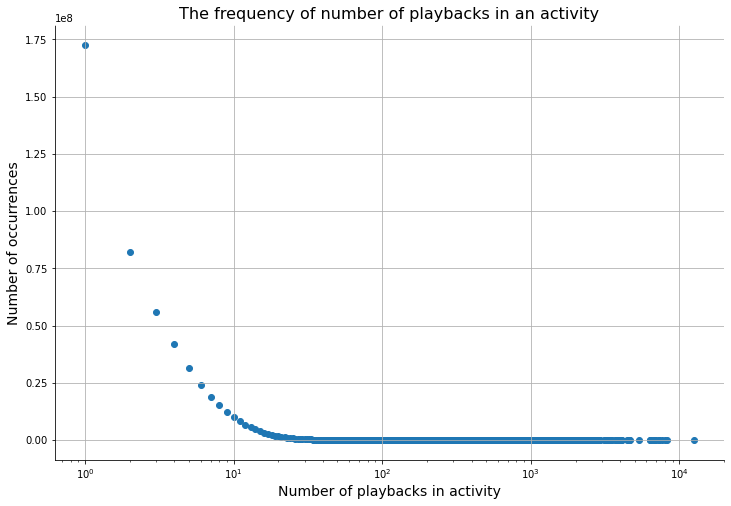

In [91]:
# Create figure and axes.
figure, axes = w.plotting.create_empty_figure()

# Plot the frequencies of the number of playbacks per activity.
axes.scatter(playbacks_per_activity_frequencies[0],
             playbacks_per_activity_frequencies[1])

# Turn on the grid.
axes.grid()

# Use logarithmic x-axis.
axes.set_xscale('log')

# Annotate.
axes.set_xlabel('Number of playbacks in activity')
axes.set_ylabel('Number of occurrences')
axes.set_title('The frequency of number of playbacks in an activity')

# Apply standard formatting.
w.plotting.format_axes_annotation(axes)
w.plotting.format_axes(axes)

# Save the plot for use in the report.
t.save_plot('playback_per_activity_plot', figure)


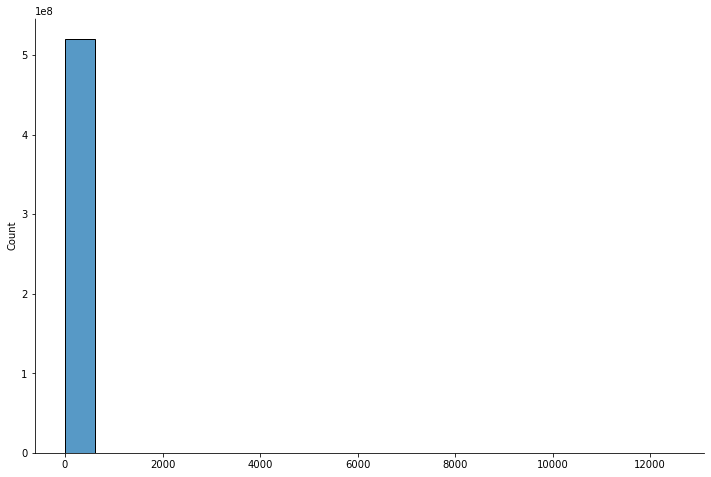

In [78]:
figure, axes = w.plotting.create_empty_figure()

sns.histplot(data=playbacks_per_activity_count,
             bins=20,
             ax=axes)

# Data about the *playback devices*
<hr style="border:2px solid black"></hr>


# Data about the *audio tracks*
<hr style="border:2px solid black"></hr>


# Stat summary
<hr style="border:2px solid black"></hr>


## Number of undefined entries

In [146]:
# To make the numbers easier to read, transform the
# number of cells to a string
if isinstance(dfp_undefined[('Undefined', 'Number of cells')].iat[0], (int, float)):
    dfp_undefined[('Undefined', 'Number of cells')] = (
        dfp_undefined[('Undefined', 'Number of cells')]
        .apply('{:,.0f}'.format)
    )

# Save the dataframe to pickle
dfp_undefined.to_pickle(Config.Path.initial_stats_df_n_undefined)

# Show the result
display(dfp_undefined)

Undefined      
                        Number of cells     %
activity_id                           0  0.00
activity_start_time                   0  0.00
activity_duration                     0  0.00
device_id                       7253534  0.29
device_name                   7,258,178  0.29
track_artist                710,429,434 28.07
track_title                 180,364,595  7.13
track_player                338,135,480 13.36
track_start_time                      0  0.00
track_playback_duration               0  0.00
track_spotify_uri         2,033,877,221 80.38
track_sony_uri              496,936,211 19.64
user_id                               0  0.00

In [ ]:
# If saved before, it is also possible to load the
# dataframe from pickle.
dfp_undefined = pd.read_pickle(
    Config.Path.initial_stats_df_n_undefined)

# Show the result
display(dfp_undefined_entries)

## Number of distinct entries

In [129]:
# To make the numbers easier to read, transform the
# number of cells to a string
if isinstance(dfp_distinct['Number of distinct values'].iat[0], (int, float)):
    dfp_distinct['Number of distinct values'] = (
        dfp_distinct['Number of distinct values']
        .apply('{:,.0f}'.format)
    )

# Save the dataframe to pickle
dfp_distinct.to_pickle(Config.Path.initial_stats_df_n_distinct)

# Show the result
display(dfp_distinct)

,Number of distinct values
,
user_id,"4,228,782"
activity_id,"520,747,470"
activity_start_time,"519,487,179"
activity_duration,"235,387"
device_id,"4,742,108"
device_name,"4,188"
track_artist,"9,931,077"
track_title,"73,003,873"
track_player,4


In [ ]:
# If saved before, it is also possible to load the
# dataframe from pickle.
dfp_distinct = pd.read_pickle(
    Config.Path.initial_stats_df_n_distinct)

# Show the result
display(dfp_distinct)

## Combined stats

Create or load the dataframe containing the stats:

In [ ]:
dfp_combined_stats = pd.concat([dfp_undefined, dfp_distinct],
                               axis=1)

In [15]:
dfp_combined_stats = pd.read_pickle(Config.Path.initial_stats_df_combined_stats)

# To make the numbers easier to read, transform the
# number of cells to a string.
for idx, row in dfp_combined_stats.iterrows():
    if isinstance(row[('Undefined', 'Number of cells')],
                  (int, float)):
        dfp_combined_stats.loc[idx, ('Undefined', 'Number of cells')] = \
            f"{dfp_combined_stats.loc[idx, ('Undefined', 'Number of cells')]:,.0f}"
    
display(dfp_combined_stats)

Undefined       Number of distinct values
                        Number of cells     %                          
activity_id                           0  0.00               520,747,470
activity_start_time                   0  0.00               519,487,179
activity_duration                     0  0.00                   235,387
device_id                     7,253,534  0.29                 4,742,108
device_name                   7,258,178  0.29                     4,188
track_artist                710,429,434 28.07                 9,931,077
track_title                 180,364,595  7.13                73,003,873
track_player                338,135,480 13.36                         4
track_start_time                      0  0.00             2,498,319,684
track_playback_duration               0  0.00                   226,103
track_spotify_uri         2,033,877,221 80.38                10,870,457
track_sony_uri              496,936,211 19.64                 3,344,649
user_id                               0  0.00                 4,228,782

In [20]:
# Save the combined stats.
dfp_combined_stats.to_pickle(Config.Path.initial_stats_df_combined_stats)

# Show the result.
display(dfp_combined_stats)

# Save the table in the LaTeX format for the report.
t.save_table(dfp_combined_stats, 'initial_stats_number_of_undefined_and_disitinct_values')

Undefined       Number of distinct values
                        Number of cells     %                          
activity_id                           0  0.00               520,747,470
activity_start_time                   0  0.00               519,487,179
activity_duration                     0  0.00                   235,387
device_id                     7,253,534  0.29                 4,742,108
device_name                   7,258,178  0.29                     4,188
track_artist                710,429,434 28.07                 9,931,077
track_title                 180,364,595  7.13                73,003,873
track_player                338,135,480 13.36                         4
track_start_time                      0  0.00             2,498,319,684
track_playback_duration               0  0.00                   226,103
track_spotify_uri         2,033,877,221 80.38                10,870,457
track_sony_uri              496,936,211 19.64                 3,344,649
user_id                               0  0.00                 4,228,782

Saving table to: "/data/work/shared/s001284/Music_Project/documentation/report/src/resources/tables/initial_stats_number_of_undefined_and_disitinct_values.tex".
	Done.


# Stuff from January
<hr style="border:2px solid black"></hr>
<hr style="border:2px solid black"></hr>


In [6]:
display(
    df_full
    .where(f.col('track_spotify_uri').isNotNull())
    .limit(5)
    .toPandas()
)

,user_id,activity_id,activity_start_time,activity_duration,device_id,device_name,track_artist,track_title,track_album,track_player,track_start_time,track_playback_duration,track_spotify_uri,track_sony_uri
0,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,Maluma,Borro Cassette,Borro Cassette,Spotify,2015-10-01 14:43:32.389,216,spotify:track:2ocDZVhBiGCaaZRNW3fmSd,None
1,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,Reykon,Imaginándote (feat. Daddy Yankee),Imaginándote (feat. Daddy Yankee),Spotify,2015-10-01 14:47:08.233,224,spotify:track:3AQ1zVx39FvB4yH0bjGgPm,None
2,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,Calle 13,Atrévete Te Te,Calle 13 (Explicit Version),Spotify,2015-10-01 14:50:52.873,239,spotify:track:1q8NdCAQ9QUjpYiqzdd3mv,None
3,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,Mr. Probz,Waves - Robin Schulz Radio Edit,Waves,Spotify,2015-10-01 14:54:51.387,207,spotify:track:5Sf3GyLEAzJXxZ5mbCPXTu,None
4,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,La Arrolladora Banda El Limón De Rene Camacho,Mi Segunda Vida,Gracias Por Creer,Spotify,2015-10-01 14:58:18.674,187,spotify:track:6Z7f0BXDLI8k4CHR9KJdAD,None


## Types of `track_sony_uri`

In [7]:
display(
    df_full
    .withColumn('track_uri_type',
                f.when(f.length('track_sony_uri') >= 20,
                       f.substring('track_sony_uri', 1, 20))
                .otherwise(f.col('track_sony_uri')))
    .select('track_uri_type')
    .distinct()
    .toPandas()
)

# n_types_of_track_uri = df_types_of_track_uri.count()
# print(f'The number of distinct track uri types is: {n_types_of_track_uri}')

,track_uri_type
0,http://podcast.wfmu.
1,http://onethinginafr
2,http://arabic.podhos
3,http://mvod1.akcdn.r
4,http://vcook.podOmat
...,...
3262,http://emotionalchan
3263,http://static.audiof
3264,http://192.168.30.10
3265,http://terryguindi.p


In [ ]:
df_types_of_track_uri = (
    df
    .withColumn('track_uri_type',
                f.when(f.length('track_uri') >= 20,
                       f.substring('track_uri', 1, 20))
                .otherwise(f.col('track_uri')))
    .select('track_uri_type')
    .distinct()
)

n_types_of_track_uri = df_types_of_track_uri.count()
print(f'The number of distinct track uri types is: {n_types_of_track_uri}')

In [ ]:
# Display the table.
if display_middle_results:
    df_types_of_track_uri.limit(100).toPandas().head(5)

In [ ]:
df_track_uri_prefix = (
    df
    .where(f.col('track_uri').isNotNull())
    .withColumn('track_uri_prefix',
                 f.substring_index('track_uri', ':', 1))
    .select(['track_uri_prefix', 'track_uri'])
    .dropDuplicates(['track_uri_prefix'])
)

n_uri_prefix = df_track_uri_prefix.count()
print(f'The number of distinct track uri types is: {n_uri_prefix}')

# Display the table.
if display_middle_results:
    df_track_uri_prefix.limit(100).toPandas().head(5)

In [ ]:
dfp_track_uri_prefix = df_track_uri_prefix.limit(10).toPandas()

## Types of `track_spotify_uri`

In [ ]:
df_types_of_track_id = (
    df
    .withColumn('track_id_type',
                f.when(f.length('track_id') >= 7, 
                       f.substring('track_id', 1, 7))
                .otherwise(f.col('track_id')))
    .select(['track_id_type', 'track_id'])
    .dropDuplicates(['track_id_type'])
)

# Count the number of track id's
n_types_of_track_id = df_types_of_track_id.count()
print(f'The number of distinct track uri types is: {n_types_of_track_id}')

In [ ]:
# Display the dataframe.
if display_middle_results:
    df_types_of_track_id.limit(100).toPandas().head(5)

## Coappearence of  `track_id` and  `track_uri`

In [ ]:
n_track_id_and_uri_nonempty = (
    df
    .where((f.col('track_uri').isNotNull())
           & (f.col('track_id').isNotNull()))
    .count()
)

print(f'Number of rows where both "tracks_id" and '
      f'"tracks_uri" are full: {n_track_id_and_uri_nonempty}.')

## Rows where `track_uri` is a local path and the platform is not Walkman

In [ ]:
df_a = (
    df
    .where(f.substring('track_uri', 1, 37) == 'content://media/external/audio/media/')
    .where(f.col('track_player') != 'Walkman')
)

# Display the table.
if display_middle_results:
    df_a.limit(100).toPandas().head(5)


In [ ]:
df_b = (
    df
    .where(f.substring('track_uri', 1, 37) == 'content://media/external/audio/media/')
    .where(f.col('track_player') != 'Walkman')
)

# Display the table.
if display_middle_results:
    df_a.limit(100).toPandas().head(5)

In [ ]:
df_b = (
    df.withColumn('track_id_prefix', 
                 f.when(f.col('track_uri').isNull()))
    
    .where(f.substring('track_uri', 1, 37) == 'content://media/external/audio/media/')
    .where(f.col('track_player') != 'Walkman')
)

# Display the table.
if display_middle_results:
    df_a.limit(100).toPandas().head(5)

# Statistics
<hr style="border:2px solid black"></hr>


## Visualize the amount of undefined cells in each column

### As table

Count the undefined cells in each column:

In [ ]:
## COUNT THE UNDEFINED CELLS

# Initialize the dict where the numbers will be stored.
n_undefined = dict()
pct_undefined = dict()

# Count the undefined cells in each column.
for column_name in tqdm(df.columns):
    n_undefined[column_name] = df.where(f.col(column_name).isNull()).count()
    pct_undefined[column_name] = n_undefined[column_name] / n_rows_total * 100

    
## DISPLAY RESULTS AS PANADAS TABLE

# Define the column names.
property_names = ['Number of cells', 'Percent of total'] 

# Create a dict representing the data.
data = {column_name: [f'{n_undefined[column_name]:,.0f}',
                      f'{pct_undefined[column_name]:.2f}']
        for column_name in n_undefined.keys()}

# Create the pandas dataframe for displaying.
dfp_undefined = pd.DataFrame.from_dict(data,
                                       orient='index',
                                       columns=property_names)

# Display the dataframe
display(dfp_undefined)

In [ ]:
t.save_table(dfp_undefined, 'undefined_cells_in_full_database')

### As bargraph

Create a bargraph represening the percentage of undefined cells in each column:

In [ ]:
# Create a barplot showing the percentage of undefined values in each column.
axes = sns.barplot(x=list(pct_undefined.keys()),
                   y=list(pct_undefined.values()))

# Rotate the tick labels for the x-axes.
labels = axes.set_xticklabels(axes.get_xticklabels(),
                              rotation=45,
                              ha='right',
                              va='top',
                              fontsize=14
                             )

# Annotate the graph.
title = axes.set_title('Percentage of undefined values by column')
# x_label = axes.set_xlabel('Column name')
y_label = axes.set_ylabel('Percentage of undefined values')

# Apply general formatting.
w.format_figure(axes.figure)

# Save the figure
# t.save_plot('percentage_of_undefined_cells_in_full_database')
plt.savefig(Config.Path.report_images_root / 'percentage_of_undefined_cells_in_full_database.eps')

## Visualize activities over time

In [ ]:
# Compute dataframe showing the number of activities and the total duration
# of these activities per day. Order by activity date.
df_activity_stats = (
    df
    .withColumn('activity_date', f.to_date('activity_start_time'))
    .groupBy('activity_date')
    .agg(f.count('activity_id').alias('n_activities'),
         f.sum('activity_duration').alias('activity_duration_sum'))
    .orderBy(f.asc('activity_date'))
)

# Show the top rows
df_activity_stats.limit(100).toPandas().head(10)

In [ ]:
# # Histogram
# buckets = [int(10*1.2**i) for i in range(0,30)]
# price_histogram = df_listings_rome.select('price').rdd.flatMap(lambda x: x).histogram(buckets)

def get_column(df, column_name):
    return df.select(column_name).rdd.flatMap(lambda x: x).collect()

date = get_column(df_activity_stats, 'activity_date')
n_activities = get_column(df_activity_stats, 'n_activities')
duration_sum = get_column(df_activity_stats, 'activity_duration_sum')

In [ ]:
# Create a figure and axes for the plot.
figure, axes_left = w.empty_figure()

# Create a twin axes for two different y-axes on the same plot.
axes_right = axes_left.twinx()

# Plot the data
plot_left = axes_left.plot(date, np.array(n_activities) / 1e6,
                      color='red',
                      label='Number of daily activities')

plot_right = axes_right.plot(date, np.array(duration_sum) / (3600 * 1e6),
                         color='blue',
                         label='Sum of duration of daily activites')

# Set titles and labels.
title = axes_left.set_title('Daily actvity')
xlabel = axes_left.set_xlabel('')
ylabel_left = axes_left.set_ylabel('Number of activities [millions]')
ylabel_right = axes_right.set_ylabel('Time spent on activities [millions of hours]')

# Set tickmarks.
axes_left.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
x_lim = axes_left.set_xlim((datetime.datetime(2014, 1, 1), datetime.datetime(2020, 1, 1)))
plot = plt.setp(axes_left.get_xticklabels(),
                rotation=45,
                ha="right",
                va='top',
                rotation_mode="anchor",
                fontsize=14)

# Set limits
y_lim_left = axes_left.set_ylim((0, 5))
y_lim_right = axes_right.set_ylim((0, 5))

# Set layout
axes = figure.axes
for ax in axes:
    ax.spines['top'].set_color('white')
    ax.set_facecolor("white")
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    ax.title.set_fontsize(20)
    
axes_left.yaxis.label.set_color('red')
axes_right.yaxis.label.set_color('blue')

# Set grid
axes_left.xaxis.grid(which="both", linewidth=0.5)
axes_left.yaxis.grid(which="both", linewidth=0.5)
axes_right.grid(None)

# Add a legend
all_plots = plot_left + plot_right
all_labels = [plot.get_label() for plot in all_plots]
legend = axes_left.legend(all_plots, all_labels, loc=0)

# Save the figure
# t.save_plot('daily_activity_vs_time')
figure.savefig(Config.Path.report_images_root / 'daily_activity_vs_time.eps')

# Save the dataframe
<hr style="border:2px solid black"></hr>

In [ ]:
# Save the start time for timing.
start_time = time.time()

# Save the dataframe with partitions defined by the first
# two letters of the user ID.
(df
 .withColumn('user_id_prefix', f.col('user_id').substr(0,2))
 .write.mode('overwrite')
 .partitionBy('user_id_prefix')
 .parquet(str(Config.Path.project_data_root / 'df_clean_new'))
)

# Print the execution time.
print(f'Execution time: {time.time() - start_time:.5f} s.')